In [ ]:
!pip install pytorch-tabnet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer
import random # Import the random module

# Reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

In [ ]:
# Load data
train_df = pd.read_csv("/content/drive/MyDrive/bitirme/TRAIN2.csv")
test_df=pd.read_csv("/content/drive/MyDrive/bitirme/final_augmented_with_HbA2.csv")

In [ ]:
# Preproces
target_col = "Interpretation"
train_df.drop(columns=["id"], inplace=True)
test_ids = test_df["id"]
test_df.drop(columns=["id"], inplace=True)

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Stratified split yapmadan önce y'yi tanımlamalısın
y = train_df["Interpretation"]  # orijinal etiketler

# Stratified split
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_idx, val_idx = next(skf.split(train_df.drop(columns=["Interpretation"]), y))

y_train_raw = y.iloc[train_idx]
y_val_raw = y.iloc[val_idx]

print("Eğitim etiketleri:", sorted(y_train_raw.unique()))
print("Doğrulama etiketleri:", sorted(y_val_raw.unique()))


Eğitim etiketleri: ['Alpha thal trait', 'Alpha thal1 trait', 'Beta thal trait', 'Beta0 thal/Hb E disease', 'FA2', 'Hb CS trait', 'Hb E Homozygote', 'Hb E trait', 'Hb E trait + Alpha thal1 trait', 'Hb H disease', 'Normal Hb type']
Doğrulama etiketleri: ['Alpha thal trait', 'Alpha thal1 trait', 'Beta thal trait', 'Beta0 thal/Hb E disease', 'FA2', 'Hb CS trait', 'Hb E Homozygote', 'Hb E trait', 'Hb E trait + Alpha thal1 trait', 'Hb H disease', 'Normal Hb type']


In [ ]:
# Örneklemden sonra veriyi karıştır
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
# Encode categoricals
label_encoders = {}
for col in train_df.columns:
    if train_df[col].dtype == "object" and col != target_col:
        le = LabelEncoder()
        all_values = pd.concat([train_df[col], test_df[col]], axis=0)
        le.fit(all_values)
        train_df[col] = le.transform(train_df[col])
        test_df[col] = le.transform(test_df[col])
        label_encoders[col] = le

In [ ]:
# Encode target
target_le = LabelEncoder()
train_df[target_col] = target_le.fit_transform(train_df[target_col])
num_classes = train_df[target_col].nunique()

X = train_df.drop(columns=[target_col])
y = train_df[target_col]
X_test = test_df.copy()

In [ ]:
# Train veri setinde tekrarlı kayıt varsa sil (önce yapılmalı!)
train_df = train_df.drop_duplicates().reset_index(drop=True)

# Hedef ve özellikleri ayır
target_col = "Interpretation"
y_raw = train_df[target_col].reset_index(drop=True)
X_raw = train_df.drop(columns=[target_col]).reset_index(drop=True)

# Standardize
scaler = StandardScaler()
X_scaled_raw = scaler.fit_transform(X_raw)

# Aynı değerleri içeren satırları sil (round ile minik farkları yok sayıyoruz)
X_df = pd.DataFrame(X_scaled_raw).round(5)
X_df["target"] = y_raw.values

# Tekrarlayanları kaldır
X_df = X_df.drop_duplicates().reset_index(drop=True)

# Son X ve y
y = X_df["target"]
X_scaled = X_df.drop(columns=["target"]).values


# Test verisinden hedef/ID'leri çıkar
X_test = test_df.copy()
X_test.drop(columns=["id", "Interpretation"], inplace=True, errors="ignore")

# Sınıf ağırlıkları (class weight)
from sklearn.utils.class_weight import compute_class_weight
import torch
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

# Stratified split (veri sızıntısız)
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in skf.split(X_scaled, y):
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    break

# Eğitim ve doğrulama çakışıyor mu kontrol et
matches = 0
for i in range(len(X_val)):
    if any(np.all(X_val[i] == row) for row in X_train):
        matches += 1
print(f"🔍 {matches} validation örneği, eğitimde birebir aynı!")


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


🔍 0 validation örneği, eğitimde birebir aynı!


In [ ]:
# TabNet Model
tabnet = TabNetClassifier(
    input_dim=X_train.shape[1],
    output_dim=num_classes,
    n_d=32, n_a=32,
    n_steps=3,
    gamma=1.3,
    lambda_sparse=1e-2,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-3),
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='entmax'
)

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [ ]:
# y_train içindeki her örnek için, ait olduğu sınıfın ağırlığını ata
sample_weights = np.array([class_weights[label] for label in y_train])

In [ ]:
# 1. Class weights (sınıf bazlı)
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights = dict(enumerate(class_weights))  # Eğer gerekirse dict yap

# 2. Sample weights (örnek bazlı)
sample_weights = np.array([class_weights[label] for label in y_train])

!pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# Then import the necessary libraries
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
# Fit
tabnet.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_name=['train', 'val'],
    eval_metric=['accuracy'],
    max_epochs=50,
    patience=5,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    weights=sample_weights,
    drop_last=False
)


Looking in indexes: https://download.pytorch.org/whl/cu118
epoch 0  | loss: 3.24584 | train_accuracy: 0.08333 | val_accuracy: 0.05747 |  0:00:00s
epoch 1  | loss: 2.75155 | train_accuracy: 0.08333 | val_accuracy: 0.06897 |  0:00:01s
epoch 2  | loss: 2.37957 | train_accuracy: 0.08621 | val_accuracy: 0.08046 |  0:00:01s
epoch 3  | loss: 2.24017 | train_accuracy: 0.1092  | val_accuracy: 0.09195 |  0:00:01s
epoch 4  | loss: 2.12022 | train_accuracy: 0.08046 | val_accuracy: 0.11494 |  0:00:02s
epoch 5  | loss: 1.96825 | train_accuracy: 0.12069 | val_accuracy: 0.12644 |  0:00:02s
epoch 6  | loss: 1.77336 | train_accuracy: 0.13506 | val_accuracy: 0.14943 |  0:00:02s
epoch 7  | loss: 1.66187 | train_accuracy: 0.1408  | val_accuracy: 0.18391 |  0:00:02s
epoch 8  | loss: 1.54003 | train_accuracy: 0.15805 | val_accuracy: 0.1954  |  0:00:02s
epoch 9  | loss: 1.48214 | train_accuracy: 0.17241 | val_accuracy: 0.2069  |  0:00:02s
epoch 10 | loss: 1.44903 | train_accuracy: 0.18391 | val_accuracy: 0.21

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
print(tabnet.history)

{'loss': [3.24583852154085, 2.7515474379747764, 2.3795669407680116, 2.2401672368762138, 2.120222330093384, 1.9682547717258847, 1.7733592904847244, 1.6618730377876896, 1.540026901782244, 1.482135700083327, 1.4490329794500065, 1.2955962912789707, 1.3485836900513748, 1.1770895459186073, 1.1706801556992805, 1.098706002893119, 1.1511420148542557, 1.002208371957143, 0.9501229099843694, 0.846238354841868, 0.8327947807037968, 0.7883788354095371, 0.8861835044005821, 0.6633721843533132, 0.7813505386484081, 0.6569285851785507, 0.6293069679161598, 0.757197043676486, 0.6182333018587923, 0.5898561114552378, 0.5018152779546278, 0.5553428695119661, 0.5757252642478066, 0.5033720680351915, 0.46265652775764465, 0.44596422540730446, 0.42778218888688363, 0.43168330021288204, 0.3968865395277396, 0.35667170738351756, 0.3650279904919109, 0.35839438986504213, 0.36805407857072764, 0.3097702384680167, 0.27249335831609267, 0.470757694765069, 0.35735020486787816, 0.32085780919283285, 0.3101445657425913, 0.29098044

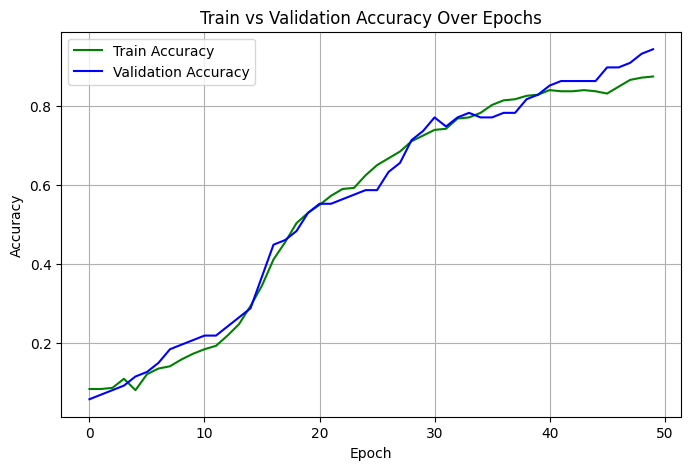

In [ ]:
import matplotlib.pyplot as plt
train_acc = tabnet.history['train_accuracy']
val_acc = tabnet.history['val_accuracy']

plt.figure(figsize=(8,5))
plt.plot(train_acc, label='Train Accuracy', color='green')
plt.plot(val_acc, label='Validation Accuracy', color='blue')
plt.title("Train vs Validation Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Optional: extract TabNet features and pass to custom head
train_feats = tabnet.predict_proba(X_train)
val_feats = tabnet.predict_proba(X_val)

In [ ]:
# Custom classifier (dense layers on top of TabNet output)
class CustomHead(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
# 1. TRAIN VERİSİNDE TEKRAR EDEN KAYIT VAR MI?
dup_count = train_df.duplicated().sum()
print(f"\n🔍 Duplicate kayıt sayısı (train_df): {dup_count}")


🔍 Duplicate kayıt sayısı (train_df): 0


In [ ]:
# 2. VALIDASYON VERİSİ EĞİTİM VERİSİYLE BİREBİR Mİ?
matches = 0
for i in range(len(X_val)):
    if any(np.all(X_val[i] == row) for row in X_train):
        matches += 1
print(f"🔍 {matches} validation örneği, eğitimde birebir aynı!")

🔍 0 validation örneği, eğitimde birebir aynı!


In [ ]:
# 3. ÖZELLİKLERİN HEDEFLE KORELASYONU
X_df = pd.DataFrame(X_scaled, columns=train_df.drop(columns=[target_col]).columns)
# Fix: Ensure y and X_df have the same index before assigning the 'target' column.
X_df = X_df.iloc[:len(y)]  # Select the first len(y) rows of X_df
X_df['target'] = y.values

corr = X_df.corr(numeric_only=True)['target'].abs().sort_values(ascending=False)
print("\n🔍 Hedef ile korelasyonu yüksek özellikler:")
print(corr.head(10))


🔍 Hedef ile korelasyonu yüksek özellikler:
target               1.000000
Hb A1C/Hb F          0.420363
MCV                  0.308533
Hb E                 0.266043
Hb A0                0.257069
Hb D/S/Constant/C    0.218917
Hb A2                0.187829
HB                   0.118925
Hb Bart's            0.006559
Name: target, dtype: float64


In [ ]:
# Train custom head
model = CustomHead(input_dim=train_feats.shape[1], num_classes=num_classes)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_tensor = torch.tensor(train_feats, dtype=torch.float32)
train_labels = torch.tensor(y_train.values, dtype=torch.long)
val_tensor = torch.tensor(val_feats, dtype=torch.float32)
val_labels = torch.tensor(y_val.values, dtype=torch.long)

for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    outputs = model(train_tensor)
    loss = criterion(outputs, train_labels)
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        model.eval()
        val_out = model(val_tensor)
        val_loss = criterion(val_out, val_labels)
    print(f"Epoch {epoch+1}: Train Loss {loss.item():.4f} | Val Loss {val_loss.item():.4f}")

Epoch 1: Train Loss 2.6813 | Val Loss 2.4139
Epoch 2: Train Loss 2.6033 | Val Loss 2.4080
Epoch 3: Train Loss 2.6592 | Val Loss 2.4020
Epoch 4: Train Loss 2.5246 | Val Loss 2.3958
Epoch 5: Train Loss 2.5639 | Val Loss 2.3891
Epoch 6: Train Loss 2.4427 | Val Loss 2.3821
Epoch 7: Train Loss 2.4815 | Val Loss 2.3745
Epoch 8: Train Loss 2.3837 | Val Loss 2.3663
Epoch 9: Train Loss 2.2370 | Val Loss 2.3577
Epoch 10: Train Loss 2.2754 | Val Loss 2.3486
Epoch 11: Train Loss 2.2436 | Val Loss 2.3388
Epoch 12: Train Loss 2.2170 | Val Loss 2.3281
Epoch 13: Train Loss 2.1644 | Val Loss 2.3165
Epoch 14: Train Loss 2.0814 | Val Loss 2.3042
Epoch 15: Train Loss 2.1115 | Val Loss 2.2910
Epoch 16: Train Loss 2.0052 | Val Loss 2.2768
Epoch 17: Train Loss 1.9604 | Val Loss 2.2616
Epoch 18: Train Loss 1.9975 | Val Loss 2.2452
Epoch 19: Train Loss 1.9336 | Val Loss 2.2276
Epoch 20: Train Loss 1.8421 | Val Loss 2.2088
Epoch 21: Train Loss 1.8096 | Val Loss 2.1889
Epoch 22: Train Loss 1.7439 | Val Loss 2.16

In [ ]:
print(y.value_counts(normalize=True))

target
8     0.204598
1     0.195402
10    0.140230
7     0.126437
0     0.101149
2     0.073563
6     0.057471
9     0.041379
3     0.036782
5     0.013793
4     0.009195
Name: proportion, dtype: float64


In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix

# Tahmin ve gerçek etiketler
val_preds = tabnet.predict(X_val)
val_true = y_val

# LabelEncoder sınıf adları
class_names = target_le.classes_

# Confusion matrix
cm = confusion_matrix(val_true, val_preds)

# Eğitimdeki örnek sayısı (y_train + y_val üzerinden toplam alınabilir)
train_val_labels = pd.concat([y_train, y_val], axis=0)
train_counts = pd.Series(train_val_labels).value_counts().sort_index()

# Tahmin edilen örnek sayısı (modelin tahmini)
pred_counts = cm.sum(axis=0)

# Doğru tahminler (diyagonal)
correct_counts = cm.diagonal()

# Doğruluk oranı (class level precision)
accuracy_per_class = correct_counts / pred_counts

# Tablo oluştur
summary_df = pd.DataFrame({
    "Class": class_names,
    "Train Count": train_counts.values,
    "Predicted Count": pred_counts,
    "Correct Predictions": correct_counts,
    "Accuracy": accuracy_per_class.round(4)
})

# Sırala (en fazla tahmin edilen sınıf en üstte)
summary_df = summary_df.sort_values(by="Predicted Count", ascending=False).reset_index(drop=True)

# Göster
from IPython.display import display
display(summary_df)

<ipython-input-23-f0ad426b84d8>:25: RuntimeWarning: invalid value encountered in divide
  accuracy_per_class = correct_counts / pred_counts


,Class,Train Count,Predicted Count,Correct Predictions,Accuracy
0,Alpha thal1 trait,85,18,17,0.9444
1,Hb E trait,55,14,11,0.7857
2,Hb E trait + Alpha thal1 trait,89,14,14,1.0000
3,Normal Hb type,61,13,13,1.0000
4,Alpha thal trait,44,8,8,1.0000
5,Beta thal trait,32,6,6,1.0000
6,Hb E Homozygote,25,6,5,0.8333
7,Hb H disease,18,4,4,1.0000
8,Beta0 thal/Hb E disease,16,3,3,1.0000
9,Hb CS trait,6,1,1,1.0000


                         Class  Predicted Count  Correct Predictions  Accuracy
              Alpha thal trait                8                    8    1.0000
             Alpha thal1 trait               18                   17    0.9444
               Beta thal trait                6                    6    1.0000
       Beta0 thal/Hb E disease                3                    3    1.0000
                           FA2                0                    0       NaN
                   Hb CS trait                1                    1    1.0000
               Hb E Homozygote                6                    5    0.8333
                    Hb E trait               14                   11    0.7857
Hb E trait + Alpha thal1 trait               14                   14    1.0000
                  Hb H disease                4                    4    1.0000
                Normal Hb type               13                   13    1.0000
                                precision    recall 

<ipython-input-24-3cad891e3eeb>:24: RuntimeWarning: invalid value encountered in divide
  accuracy_per_class = correct_counts / pred_counts
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to contr

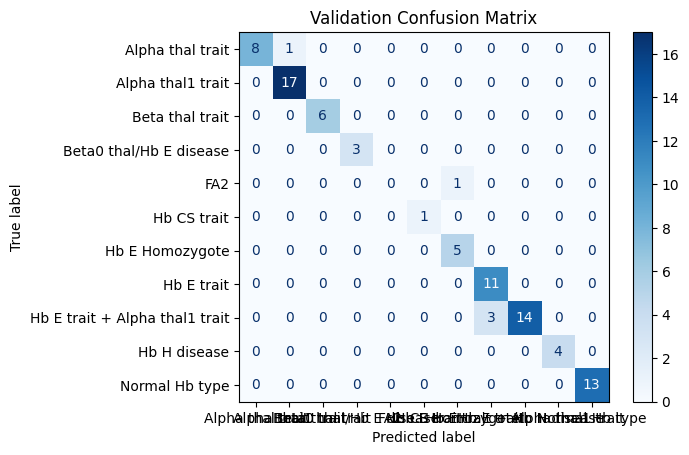

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

val_preds = tabnet.predict(X_val)

import pandas as pd
from sklearn.metrics import confusion_matrix

# Tahmin ve gerçek etiketler
val_preds = tabnet.predict(X_val)
val_true = y_val

import pandas as pd
from sklearn.metrics import confusion_matrix

val_preds = tabnet.predict(X_val)
val_true = y_val
class_names = target_le.classes_

cm = confusion_matrix(val_true, val_preds)

pred_counts = cm.sum(axis=0)
correct_counts = cm.diagonal()
accuracy_per_class = correct_counts / pred_counts

summary_df = pd.DataFrame({
    "Class": class_names,
    "Predicted Count": pred_counts,
    "Correct Predictions": correct_counts,
    "Accuracy": accuracy_per_class.round(4)
})

# Tabloyu yazdır
print(summary_df.to_string(index=False))


print(classification_report(y_val, val_preds, target_names=target_le.classes_))

cm = confusion_matrix(y_val, val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_le.classes_)
disp.plot(cmap='Blues')
plt.title("Validation Confusion Matrix")
plt.show()

In [ ]:
X_test_scaled = scaler.transform(X_test)

test_preds = tabnet.predict(X_test_scaled)
test_preds_labels = target_le.inverse_transform(test_preds)
test_results = pd.DataFrame({"id": test_ids, "Prediction": test_preds_labels})

                                precision    recall  f1-score   support

              Alpha thal trait       0.71      0.53      0.61       150
             Alpha thal1 trait       0.63      0.86      0.73       180
               Beta thal trait       0.31      0.16      0.21        74
       Beta0 thal/Hb E disease       0.00      0.00      0.00        50
                           FA2       1.00      0.84      0.91        50
                   Hb CS trait       0.89      0.96      0.92        50
               Hb E Homozygote       0.91      0.94      0.93       105
                    Hb E trait       0.87      0.95      0.91       548
Hb E trait + Alpha thal1 trait       0.38      0.51      0.43       116
                  Hb H disease       0.94      0.62      0.75        50
                Normal Hb type       0.96      0.69      0.81        78

                      accuracy                           0.76      1451
                     macro avg       0.69      0.64      0.65 

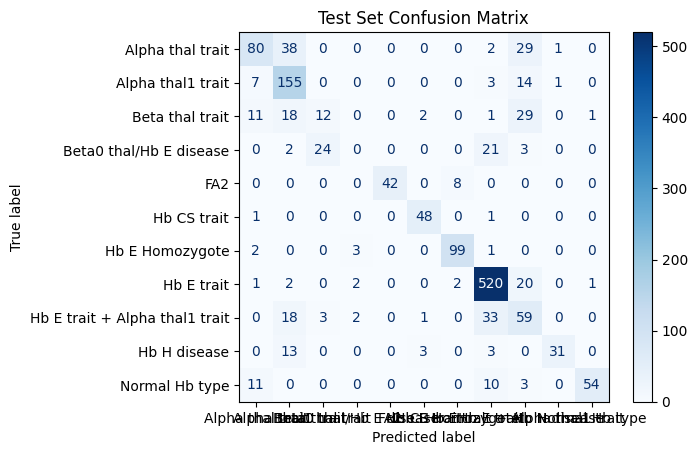

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

# Test setinde etiket varsa performans analizi yap
if "Interpretation" in test_df.columns:
    y_test_true = target_le.transform(test_df["Interpretation"])
    X_test_eval = test_df.drop(columns=["Interpretation", "id"], errors="ignore")
    X_test_scaled = scaler.transform(X_test_eval)
    y_test_pred = tabnet.predict(X_test_scaled)

    # Rapor ve Matris
    print(classification_report(y_test_true, y_test_pred, target_names=target_le.classes_))

    cm = confusion_matrix(y_test_true, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_le.classes_)
    disp.plot(cmap='Blues')
    plt.title("Test Set Confusion Matrix")
    plt.grid(False)
    plt.show()
else:
    print("⚠️ Test setinde 'Interpretation' yok, karşılaştırma yapılamaz.")

In [ ]:
# Standardize işlemi
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_test = test_df.copy()
if "Interpretation" in X_test.columns:
    X_test = X_test.drop(columns=["Interpretation"])

# Eksik olan satır:
X_test_scaled = scaler.transform(X_test)  # <<< bunu EKLE
test_preds = tabnet.predict(X_test_scaled)
test_preds_labels = target_le.inverse_transform(test_preds)
print(pd.Series(test_preds_labels).value_counts())

Hb E trait                        499
Alpha thal1 trait                 278
Hb E trait + Alpha thal1 trait    245
Hb E Homozygote                   112
Alpha thal trait                   76
Normal Hb type                     76
Beta thal trait                    50
Hb CS trait                        46
FA2                                31
Hb H disease                       30
Beta0 thal/Hb E disease             8
Name: count, dtype: int64
